In [55]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [195]:
# Nevin's pathname
pathname = '/Users/nevinaresh/Documents/CPET Research'
df = pd.read_parquet(pathname + '/combined_outcome_df.parquet')

outcomes_file = '/Users/nevinaresh/Documents/CPET Research/CPX database_outcomes_meds_10_22.xlsx'

#### Data preprocessing

In [9]:
# column names
for column_name in df.columns:
    print(column_name)

ID1
testDate
testTime
testDateTime
MRN
DOB
Height
AmbientTemp
Weight
TestDuration
AmbientRH
ExerciseDuration
firstName
lastName
Gender
Ergometer
Protocol
BarometricPress
Time
Rf
VT
VE
VO2
VCO2
RQ
O2exp
CO2exp
VE/VO2
VE/VCO2
VO2/Kg
METS
HR
VO2/HR
FeO2
FeCO2
FetO2
FetCO2
FiO2
FiCO2
SpO2
Power
Real_Power
Revolution
Speed
Grade
P_Syst
P_Diast
Phase
Ambient_Temp
RH_Amb
Analyzer_Pressure
PB
Ti
Te
Dyspnea
Leg Pain
ID
MRN-test date
Death
death_date
death_yrs
pre_arrhythm_surg
pre_arrhythm_surg_date
pre_arrhythm_surg_yrs
pre_card_surg
pre_card_surg_date
pre_card_surg_yrs
pre_acute_coronary_syndrome
pre_acute_coronary_syndrome_date
pre_acute_coronary_syndrome_yrs
pre_acute_heart_failure
pre_acute_heart_failure_date
pre_acute_heart_failure_yrs
pre_acute_respiratory_failure
pre_acute_respiratory_failure_date
pre_acute_respiratory_failure_yrs
pre_afib_flut
pre_afib_flut_date
pre_afib_flut_yrs
pre_cardiac_arrest
pre_cardiac_arrest_date
pre_cardiac_arrest_yrs
pre_cardiogenic_shock
pre_cardiogenic_sho

In [13]:
# Age
df['Age'] = (df['testDateTime'] - df['DOB']).dt.days / 365

In [14]:
# Difference between 'TestDuration' and 'Max_Time'
df['Max_Time'] = df['Time'].apply(max)
df['TestDurationTimeMaxDifference'] = abs(df['TestDuration'] - df['Max_Time'])
df['TestDurationTimeMaxDifference'].describe()

count    2089.000000
mean        4.111058
std         4.627206
min         0.000000
25%         0.000000
50%         3.000000
75%         7.000000
max        33.000000
Name: TestDurationTimeMaxDifference, dtype: float64

**Time-series data preprocessing**

In [15]:
time_series_columns = ['Time', 'Rf', 'VT', 'VE', 'VO2', 'VCO2', 'RQ', 'O2exp', 'CO2exp', 'VE/VO2', 'VE/VCO2', 'VO2/Kg', 'METS', 'HR', 'VO2/HR', 'FeO2', 'FeCO2', 'FetO2', 'FetCO2', 'FiO2', 'FiCO2', 'SpO2', 'Power', 'Real_Power', 'Revolution', 'Speed', 'Grade', 'P_Syst', 'P_Diast', 'Phase', 'Ambient_Temp', 'RH_Amb', 'Analyzer_Pressure', 'PB', 'Ti', 'Te', 'Dyspnea', 'Leg Pain']

In [16]:
def filter_time_series_columns(df, time_series_columns, skip_column, nan_threshold, empty_list_threshold):
    df_filtered = df.copy()

    for col in time_series_columns:
        if col == skip_column:
            continue
        
        # Replace arrays with an empty array if the proportion of NaN values exceeds nan_threshold
        df_filtered[col] = df_filtered[col].apply(
            lambda x: np.array([]) if pd.isna(x).mean() > nan_threshold else x
        )

        # Drop columns if the proportion of empty array exceeds empty_list_threshold
        empty_array_count = df_filtered[col].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
        total_array_count = len(df_filtered[col])
        missing_array_proportion = empty_array_count / len(df_filtered[col])
        if missing_array_proportion > 0:
            print(f"Column {col} contains {missing_array_proportion*100:.1f}% empty arrays.")
            if missing_array_proportion > empty_list_threshold:
                df_filtered.drop(columns=[col], inplace=True)

    return df_filtered

In [19]:
df_filtered = filter_time_series_columns(df, time_series_columns, skip_column='Time', nan_threshold=0.10, empty_list_threshold=0.10)

Column HR contains 0.4% empty arrays.
Column VO2/HR contains 0.4% empty arrays.
Column Power contains 87.0% empty arrays.
Column Real_Power contains 88.8% empty arrays.
Column Revolution contains 88.8% empty arrays.
Column Speed contains 13.2% empty arrays.
Column Grade contains 13.2% empty arrays.
Column P_Syst contains 86.5% empty arrays.
Column P_Diast contains 86.5% empty arrays.
Column RH_Amb contains 13.2% empty arrays.
Column Dyspnea contains 86.8% empty arrays.
Column Leg Pain contains 100.0% empty arrays.


In [22]:
filtered_time_series_columns = [col for col in time_series_columns if col in df_filtered.columns
                               and col != 'Phase']

In [619]:
def calculate_statistics_for_columns(df, time_series_columns, skip_column):
    stats_df = df.copy()
    stats_column_names = []
    
    for col in time_series_columns:
        if col == skip_column:
            continue
            
        stats_df[f"{col}_min"] = stats_df[col].apply(lambda x: np.nanmin(x) if x.size != 0 else np.nan)
        #stats_df[f"{col}_Q1"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.25) if x.size != 0 else np.nan)
        #stats_df[f"{col}_median"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.50) if x.size != 0 else np.nan)
        #stats_df[f"{col}_Q3"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.75) if x.size != 0 else np.nan)
        stats_df[f"{col}_max"] = stats_df[col].apply(lambda x: np.nanmax(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_mean"] = stats_df[col].apply(lambda x: np.nanmean(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_std"] = stats_df[col].apply(lambda x: np.nanstd(x) if x.size != 0 else np.nan)
        # stats_column_names.extend([f"{col}_min", f"{col}_Q1", f"{col}_median", f"{col}_Q3", f"{col}_max", f"{col}_mean", f"{col}_std"])        # stats_column_names.extend([f"{col}_min", f"{col}_Q1", f"{col}_median", f"{col}_Q3", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_column_names.extend([f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_df.drop(columns=[col], inplace=True)
        
    return stats_df, stats_column_names

In [620]:
stats_df, stats_column_names = calculate_statistics_for_columns(df_filtered, filtered_time_series_columns, skip_column='Time')

### Medicine Information

In [747]:
meds = pd.read_excel(outcomes_file, sheet_name="medications")

In [748]:
meds = meds.loc[:, ~meds.columns.isin(['DOB', 'Test Date', 'age', 'Weight (pounds)', 'height (in.)',
                       'Sex: M(0)/F(1)', 'MRN-date', 'CPX sequential', 'MEDICATIONS3'])]

In [624]:
meds = meds.groupby('MRN').max().reset_index()
meds.dropna(axis=1, how='all', inplace=True)
med_cols = meds.columns[2:]

In [749]:
#meds = meds.fillna(0)
stats_df = pd.merge(stats_df, meds, 'left', on='MRN')

### Labs Information

In [750]:
labs = pd.read_excel(outcomes_file, sheet_name="Labs_stanford")

In [751]:
labs['Test Date'] = pd.to_datetime(labs['Test Date'], format='%Y/%m/%d')
ids = labs.groupby('MRN')['Test Date'].idxmax()
labs = labs.iloc[ids]

In [752]:
labs = labs.drop(columns=[col for col in labs.columns if '_date' in col]+['Test Date', 'MRN-test date', 'ID'])
lab_cols = labs.columns[1:]

In [753]:
stats_df = pd.merge(stats_df, labs, 'left', on='MRN')

### peak RER and treadmill mode

In [754]:
cpx = pd.read_excel(outcomes_file, sheet_name="CPX")

In [755]:
treadmill_df = cpx[['MRN', 'Treadmill (0) or cycle (1)', 'Test Date']]
treadmill_df['Test Date'] = pd.to_datetime(treadmill_df['Test Date'], format='%Y/%m/%d')
treadmill_df = treadmill_df.rename(columns={'Treadmill (0) or cycle (1)' : 'Treadmill'})

In [756]:
stats_df = pd.merge(stats_df, treadmill_df, 'left', left_on=['MRN', 'testDate'], right_on=['MRN', 'Test Date'])
stats_df = stats_df.drop(columns='Test Date')

### Disease

In [757]:
hcm = cpx[cpx['CPX_diagnosis_Cat1'] == 'HCM']
hcm_mrn = hcm['MRN']
hf = cpx[cpx['CPX_diagnosis_Cat1'] == 'HF']
hf_mrn = hf['MRN']
cong = cpx[cpx['CPX_diagnosis_Cat1'] == 'Cong']
cong_mrn = cong['MRN']

In [758]:
hcm_idx = stats_df[stats_df['MRN'].isin(hcm_mrn)].index
hf_idx = stats_df[stats_df['MRN'].isin(hf_mrn)].index
cong_idx = stats_df[stats_df['MRN'].isin(cong_mrn)].index

In [759]:
RER_threshold = 1.0
pkRER_greater_mrn = cpx[cpx['pk RER'] >= RER_threshold]['MRN']
pkRER_greater_idx = stats_df[stats_df['MRN'].isin(pkRER_greater_mrn)].index

#### Exploratory data analysis

In [642]:
outcome_columns = ['Death', 'composite_outcome', 'MRN']
feature_columns = stats_column_names + ['Gender', 'Age', 'Height', 'Weight', 'TestDuration', 'ExerciseDuration', 'BarometricPress', 'AmbientTemp', 'AmbientRH']

In [643]:
selected_df = stats_df[outcome_columns + feature_columns]

In [644]:
# Number of rows with at least one missing value
(selected_df.isnull().sum(axis=1) > 0).sum()

8

In [645]:
selected_df.isnull().sum().sort_values(ascending=False).head(20)

VO2/HR_std     8
VO2/HR_min     8
HR_min         8
HR_mean        8
HR_std         8
HR_max         8
VO2/HR_max     8
VO2/HR_mean    8
FiCO2_std      0
FetCO2_std     0
SpO2_min       0
FiCO2_mean     0
FiCO2_max      0
FiCO2_min      0
FiO2_std       0
FiO2_mean      0
FiO2_max       0
FiO2_min       0
FetO2_std      0
FetCO2_mean    0
dtype: int64

In [646]:
data = selected_df.dropna(axis=0, how='any')

In [647]:
data = pd.merge(data, stats_df[list(med_cols) + list(lab_cols) + ['MRN', 'Treadmill']], how='inner', on='MRN')

In [648]:
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

In [649]:
data['BarometricPress'] = data.BarometricPress.astype(int)

In [650]:
categorical_columns = ['Death', 'composite_outcome', 'Gender']
numerical_columns = [col for col in data.columns if col not in categorical_columns]

**Correlation heatmap**

In [651]:
corr_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']

In [652]:
# Pearson correlation for numerical features
numerical_corr = data[corr_numerical_columns].corr(method='pearson')

In [653]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [654]:
# Cramér's V for categorical features
categorical_corr = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        categorical_corr.loc[col1, col2] = cramers_v(data[col1], data[col2])

In [655]:
# Point-Biserial Correlation for categorical-numerical Columns
categorical_numerical_corr = pd.DataFrame(index=categorical_columns, columns=corr_numerical_columns)
for cat_col in categorical_columns:
    for num_col in corr_numerical_columns:
        categorical_numerical_corr.loc[cat_col, num_col] = stats.pointbiserialr(data[cat_col], data[num_col])[0]

In [656]:
full_corr_matrix = pd.concat([
    pd.concat([categorical_corr, categorical_numerical_corr.T], axis=0),
    pd.concat([numerical_corr, categorical_numerical_corr], axis=0)
], axis=1).fillna(0).round(1)

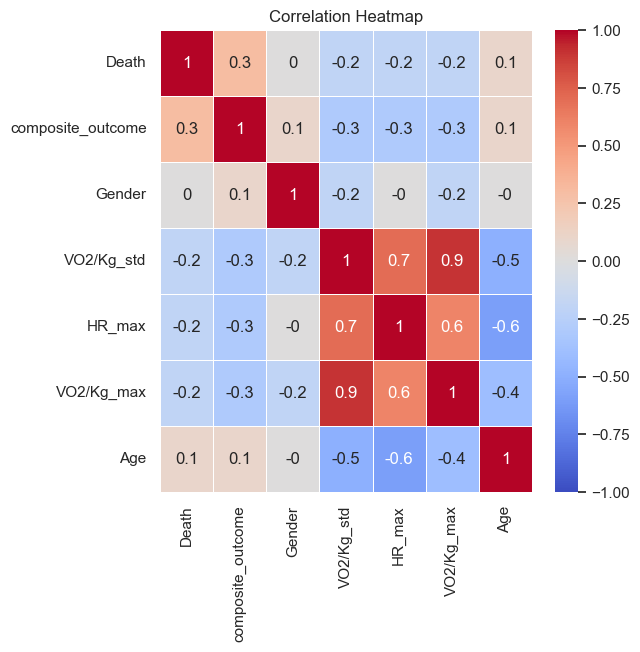

In [657]:
plt.figure(figsize=(6, 6))
sns.heatmap(full_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, center=0, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Frequency distribution**

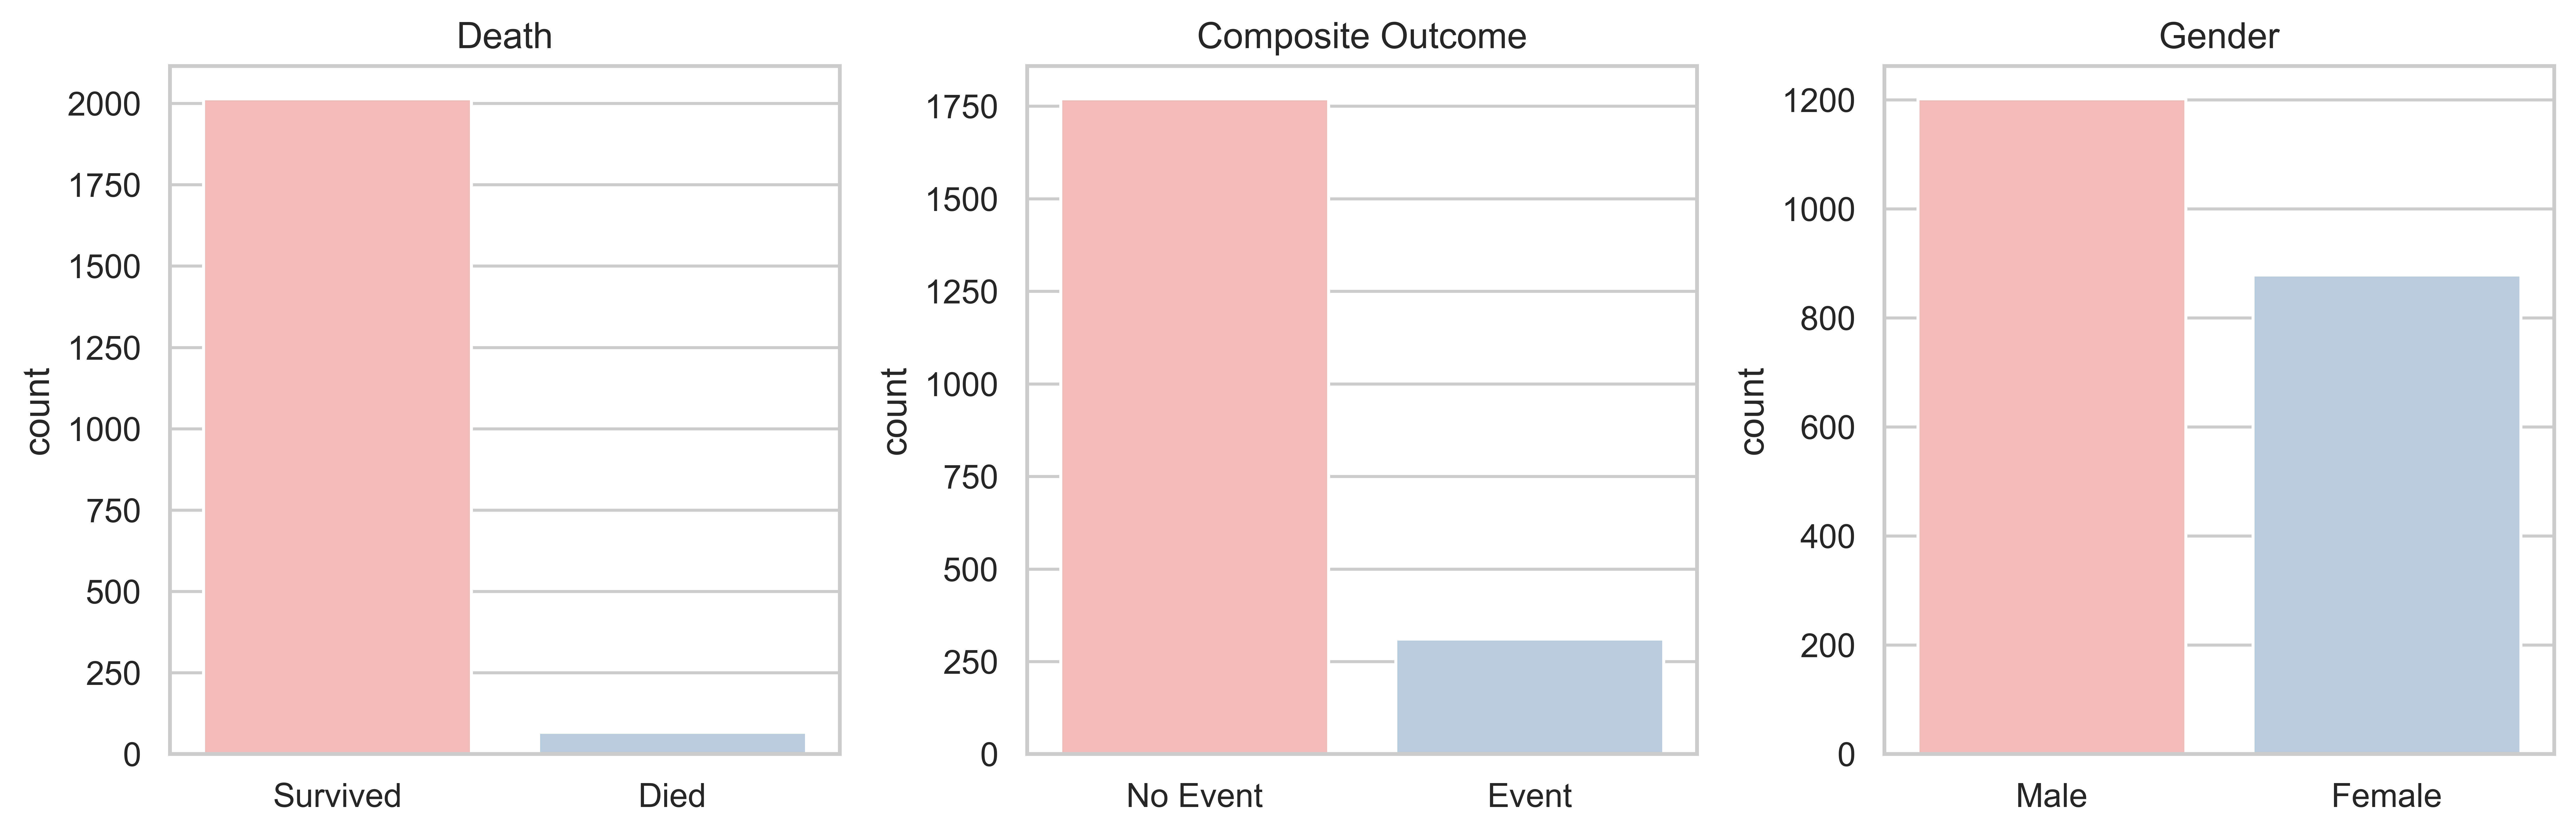

In [658]:
cat_data = data.copy()
cat_data['Death'] = cat_data['Death'].map({1: 'Died', 0: 'Survived'})
cat_data['composite_outcome'] = cat_data['composite_outcome'].map({0: 'No Event', 1: 'Event'})
cat_data['Gender'] = cat_data['Gender'].map({0: 'Male', 1: 'Female'})

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=800)
ax_title_pairs_categorical = zip(axs.flat, categorical_columns)
for ax, title in ax_title_pairs_categorical:
    sns.countplot(x=title, data=cat_data, palette='Pastel1', ax=ax)
    if title == "composite_outcome":
        ax.set_title("Composite Outcome")
    else:
        ax.set_title(title)
    ax.set_xlabel('')
plt.tight_layout()

In [659]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=800)
data_grouped = data.groupby(by='Death')
selected_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']
ax_title_pairs_numerical = zip(axs.flat, selected_numerical_columns)
for ax, title in ax_title_pairs_numerical:
    sns.distplot(data_grouped.get_group(0)[title], bins=10, ax=ax, label='Survived')
    sns.distplot(data_grouped.get_group(1)[title], bins=10, ax=ax, label='Died')
    if title == 'VO2/Kg_std':
        ax.set_xlabel('SD of VO2/kg')
    elif title == 'HR_max':
        ax.set_xlabel('Max heart rate')
    elif title == 'VO2/Kg_max':
        ax.set_xlabel('Max of VO2/kg')
    else:
        ax.set_xlabel(title)
    ax.legend(title='Status')
fig.tight_layout()

In [660]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=800)
data_grouped = data.groupby(by='composite_outcome')
selected_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']
ax_title_pairs_numerical = zip(axs.flat, selected_numerical_columns)
for ax, title in ax_title_pairs_numerical:
    sns.distplot(data_grouped.get_group(0)[title], bins=10, ax=ax, label='No event')
    sns.distplot(data_grouped.get_group(1)[title], bins=10, ax=ax, label='Event')
    if title == 'VO2/Kg_std':
        ax.set_xlabel('SD of VO2/kg')
    elif title == 'HR_max':
        ax.set_xlabel('Max heart rate')
    elif title == 'VO2/Kg_max':
        ax.set_xlabel('Max of VO2/kg')
    else:
        ax.set_xlabel(title)
    ax.legend(title='Status')
fig.tight_layout()

#### Model development

In [661]:
# seed_val = 66
seed_val = 123

**Data splitting**

In [664]:
features = data[feature_columns + list(med_cols) + list(lab_cols) + ['Treadmill']]
# outcome = data['Death']
outcome = data['composite_outcome']

In [665]:
features

Rf_min  Rf_max    Rf_mean    Rf_std    VT_min    VT_max   VT_mean  \
0       4.68   46.88  23.186256  7.471942  0.223000  3.624000  2.290934   
1      12.17   57.14  28.117372  9.553282  0.209000  1.335000  0.880795   
2       9.29   34.29  21.599578  4.452925  0.397747  3.061634  1.175560   
3      10.77   40.82  22.623349  6.626090  0.480000  2.983000  1.488326   
4       5.47   63.16  27.769024  8.471721  0.221000  2.773000  1.287393   
...      ...     ...        ...       ...       ...       ...       ...   
2076    6.86   64.52  24.758793  6.835277  0.049000  1.469000  0.658435   
2077   12.47   66.67  28.932362  7.061500  0.208000  2.085000  0.883601   
2078    4.12   52.17  25.834812  8.814149  0.086000  3.681000  1.829147   
2079    4.89   48.39  23.734130  9.678859  0.071000  3.637000  1.518694   
2080    8.13   52.17  20.489953  7.865499  0.375000  2.659000  1.423330   

        VT_std  VE_min   VE_max  ...  alkp_closest_post_test_val  \
0     0.735377   5.618  111.185  ...                        76.0   
1     0.245026   4.869   56.914  ...                        74.0   
2     0.417608   8.422   52.507  ...                       150.0   
3     0.481676   7.415   80.503  ...                        53.0   
4     0.534072   3.766   90.545  ...                         NaN   
...        ...     ...      ...  ...                         ...   
2076  0.208810   3.161   28.485  ...                        70.0   
2077  0.332816   5.947   63.120  ...                         NaN   
2078  0.900927   0.364  131.687  ...                         NaN   
2079  0.604664   1.558  101.952  ...                        65.0   
2080  0.397270   5.599   68.052  ...                        77.0   

      ntprobnp_closest_post_test_val  bnp_closest_pre_test_val  \
0                                NaN                       NaN   
1                                NaN                       NaN   
2                                NaN                       NaN   
3                                NaN                       NaN   
4                                NaN                       NaN   
...                              ...                       ...   
2076                             NaN                       NaN   
2077                             NaN                       NaN   
2078                             NaN                       NaN   
2079                             NaN                       NaN   
2080                             NaN                       NaN   

      hs_crp_closest_pre_test_val  bnp_closest_post_test_val  \
0                             NaN                        NaN   
1                             4.3                        NaN   
2                             NaN                        NaN   
3                             NaN                        NaN   
4                             NaN                        NaN   
...                           ...                        ...   
2076                          NaN                        NaN   
2077                          NaN                        NaN   
2078                          NaN                        NaN   
2079                          NaN                        NaN   
2080                          NaN                        NaN   

      hs_crp_closest_post_test_val  tot_chol_closest_pre_test_val  \
0                              NaN                            NaN   
1                              4.5                          195.0   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   
...                            ...                            ...   
2076                           NaN                            NaN   
2077                           NaN                            NaN   
2078                           NaN                            NaN   
2079                           NaN  

In [666]:
x_train, x_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)
list(map(lambda x: x.shape, [features, outcome, x_train, x_test, y_train, y_test]))

[(2081, 348), (2081,), (1456, 348), (625, 348), (1456,), (625,)]

In [667]:
# Proportion of each class for the outcome
print("\nProportion of each class for the outcome in the training set:")
print((pd.Series(y_train).value_counts() / len(y_train)).round(2))

# Proportion of each class for the outcome
print("\nProportion of each class for the outcome in the test set:")
print((pd.Series(y_test).value_counts() / len(y_test)).round(2))


Proportion of each class for the outcome in the training set:
composite_outcome
0.0    0.85
1.0    0.15
Name: count, dtype: float64

Proportion of each class for the outcome in the test set:
composite_outcome
0.0    0.85
1.0    0.15
Name: count, dtype: float64


**Feature importance**

In [668]:
import xgboost as xgb
import shap
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score, f1_score
from typing import Union
from sklearn.utils import resample
from sklearn.calibration import calibration_curve

In [669]:
# XGB model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [670]:
y_pred = model.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[518,  14],
       [ 53,  40]])

In [671]:
# SHAP value for feature importance
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

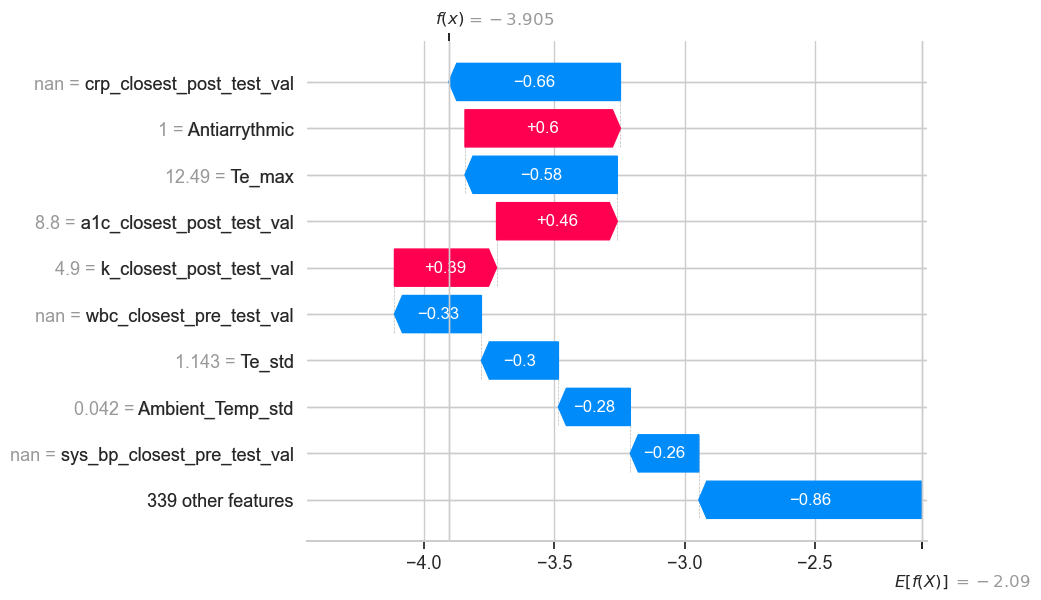

In [672]:
# Waterfall for the first patient
shap.plots.waterfall(shap_values[0])

In [673]:
shap.plots.initjs()

In [674]:
# Forceplot for the first patient
shap.plots.force(shap_values[0])
# Forceplot for the first 100 patients
#shap.plots.force(shap_values[0:100])

In [675]:
# Mean SHAP value
shap_values_df = pd.DataFrame({"feature_names": shap_values.feature_names, "values": np.mean(np.abs(shap_values.values), axis=0)}).sort_values(by="values", ascending=False)

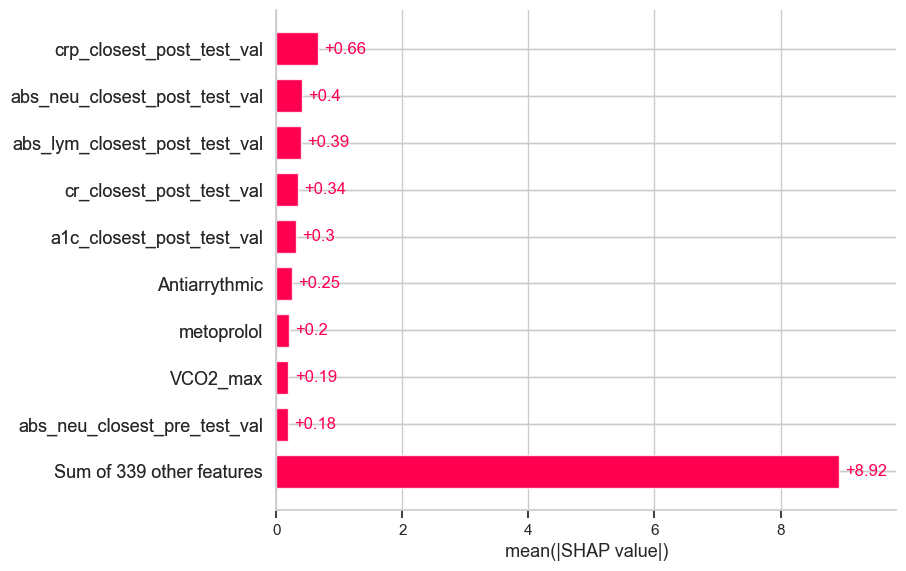

In [676]:
# Mean SHAP value for feature importance
shap.plots.bar(shap_values, max_display=10)

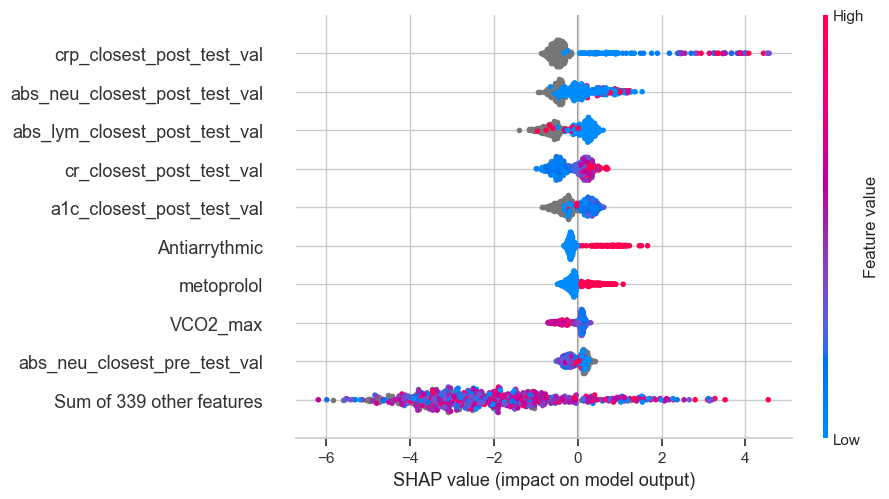

In [677]:
# Beeswarm plot for feature importance
shap.plots.beeswarm(shap_values, max_display=10)

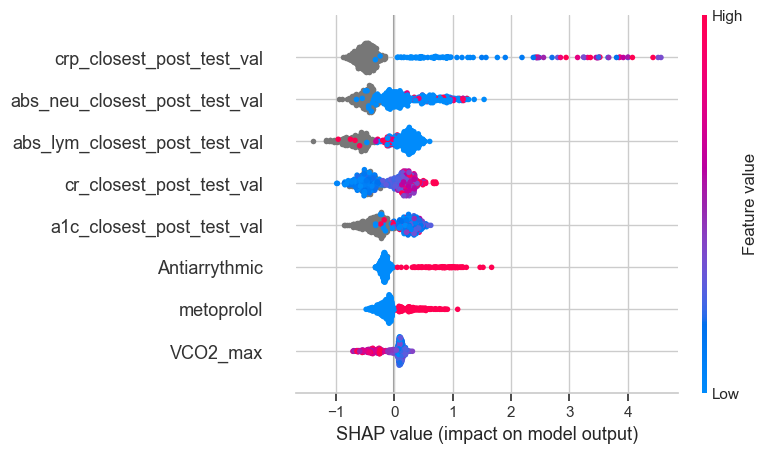

In [678]:
# Summary plot
shap.summary_plot(shap_values, x_test, max_display=8)

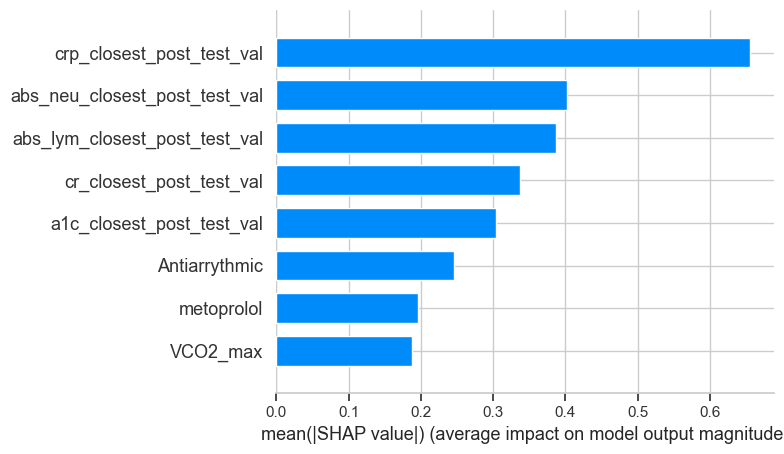

In [679]:
# Summary plot
shap.summary_plot(shap_values, x_test, max_display=8, plot_type='bar')

In [680]:
#SHAP PLOTS with just medications
#NaN for missing data

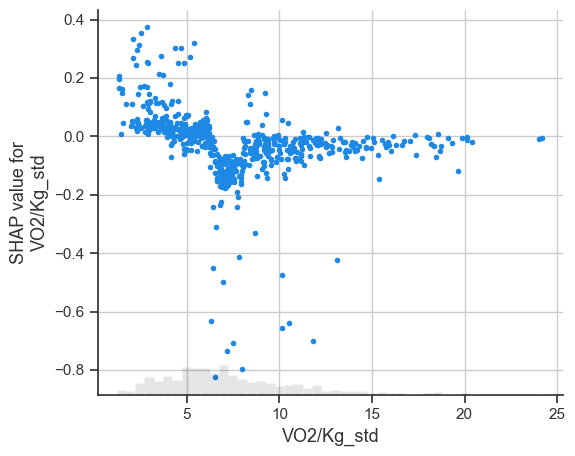

In [681]:
# Dependence plot
shap.plots.scatter(shap_values[:, "VO2/Kg_std"])

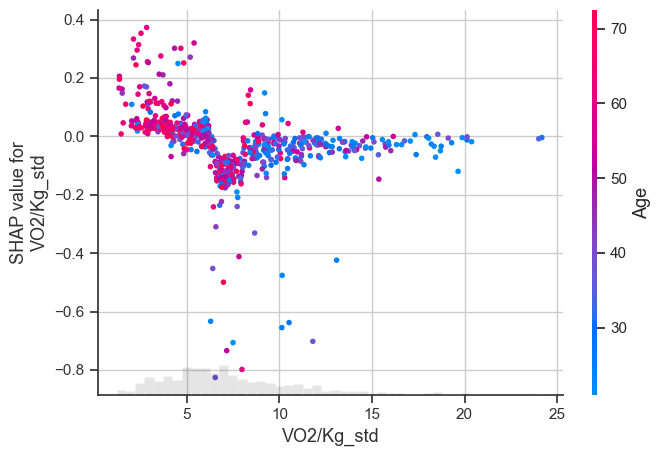

In [682]:
# Dependence plot
shap.plots.scatter(shap_values[:, "VO2/Kg_std"], color=shap_values[:, "Age"])

#### Prediction

In [683]:
# Predicted probablity
y_prob = model.predict_proba(x_test)[:,1] # Probabilities for the positive class

**Youden's index**

In [684]:
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Youden's Index for each threshold
youden_index = tpr - fpr

# Find the optimal threshold (the one that maximizes Youden's Index)
optimal_threshold_index = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print(f'Optimal Cut-off Threshold using Youden\'s Index: {optimal_threshold:.4f}')

Optimal Cut-off Threshold using Youden's Index: 0.0430


**Predicted outcome**

In [685]:
# Predicted outcome
# y_pred = (y_prob >= optimal_threshold).astype(int)
y_pred = model.predict(x_test)

In [686]:
# Group by predicted outcome and summarize the distribution of 'Death'
x_test_result = x_test.copy()
x_test_result['y_pred'] = y_pred
x_test_result['Death'] = data.loc[x_test_result.index, 'Death']
x_test_result['composite_outcome'] = data.loc[x_test_result.index, 'composite_outcome']

In [687]:
x_test_result.groupby('y_pred')['Death'].value_counts().unstack(fill_value=0)

Death   0.0  1.0
y_pred          
0       562    9
1        48    6

In [688]:
x_test_result.groupby('composite_outcome')['Death'].value_counts().unstack(fill_value=0)

Death              0.0  1.0
composite_outcome          
0.0                525    7
1.0                 85    8

#### Model performance

**Confusion matrix**

In [689]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[518,  14],
       [ 53,  40]])

In [690]:
tn, fp, fn, tp = conf_mat.ravel()

# Precision (Positive Predictive Value)
precision = tp / (tp + fp)

# Recall (Sensitivity)
recall = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Sensitivity (same as recall)
sensitivity = recall

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)

# Positive Predictive Value (PPV)
ppv = precision  # Same as precision

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# Printing all the metrics
print(f'Precision (PPV): {precision:.3f}')
print(f'Recall (Sensitivity): {recall:.3f}')
print(f'Specificity: {specificity:.3f}')
print(f'Sensitivity: {sensitivity:.3f}')
print(f'Negative Predictive Value (NPV): {npv:.3f}')
print(f'Positive Predictive Value (PPV): {ppv:.3f}')
print(f'Accuracy: {accuracy:.3f}')
print(f'F1 Score: {f1:.3f}')

Precision (PPV): 0.741
Recall (Sensitivity): 0.430
Specificity: 0.974
Sensitivity: 0.430
Negative Predictive Value (NPV): 0.907
Positive Predictive Value (PPV): 0.741
Accuracy: 0.893
F1 Score: 0.544


In [691]:
def confusion_plot(matrix, labels=None):
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

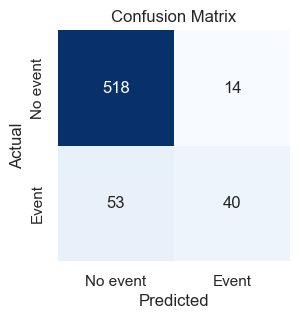

In [692]:
confusion_plot(conf_mat, labels=['No event', 'Event'])

**AUC value & ROC curve**

In [693]:
def calc_roc_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:

    # Define thresholds: 1000 equally spaced values between 0 and 1
    thresholds = np.linspace(0, 1, 1000)
    
    # Initialize arrays for FPR and TPR
    fprs = []
    tprs = []
    
    # Loop over each threshold and calculate FPR and TPR
    for threshold in thresholds:
        # Predicted positive based on threshold
        predicted_positive = (y_prob >= threshold).astype(int)
        
        # Calculate True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
        tp = np.sum((predicted_positive == 1) & (y_true == 1))
        fp = np.sum((predicted_positive == 1) & (y_true == 0))
        fn = np.sum((predicted_positive == 0) & (y_true == 1))
        tn = np.sum((predicted_positive == 0) & (y_true == 0))
        
        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity or recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # 1 - Specificity
        
        # Append the calculated rates
        tprs.append(tpr)
        fprs.append(fpr)

    fprs = np.array(fprs)
    tprs = np.array(tprs)
    
    return fprs, tprs

In [694]:
def display_roc_curve(
    fpr_tpr_list: list[tuple[np.ndarray, np.ndarray]],
    model_name_list: list[str],
    filename: Union[str, None] = None,
):
    # Plot the ROC curve using seaborn
    sns.set()
    plt.figure()
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))

    # Plot each ROC curve
    for (fpr, tpr), model_name in zip(fpr_tpr_list, model_name_list):
        plt.plot(fpr, tpr, label=model_name, linewidth=2)
    
    # Add the diagonal line for random performance
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Performance')

    # Set axis labels and title
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

    # Add legend
    plt.legend(fontsize=12, loc='lower right')

    # Adjust layout and save the plot if a filename is provided
    plt.tight_layout()
    if filename:
        plt.savefig(filename, format='png')

    # Show the plot
    plt.show()

<Figure size 640x480 with 0 Axes>

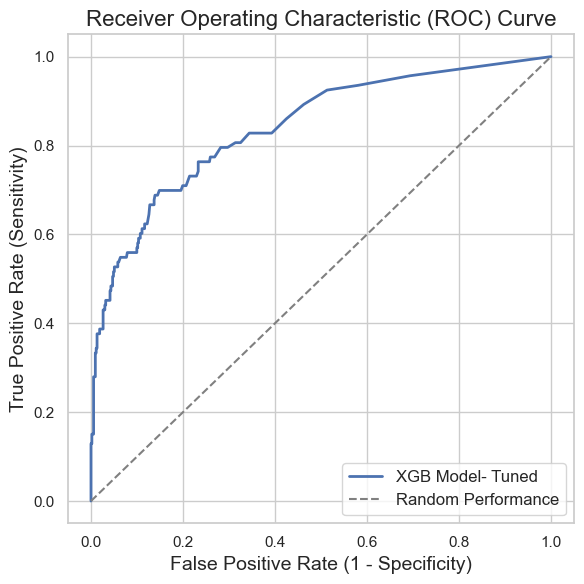

In [695]:
fpr, tpr = calc_roc_curve(y_test, y_prob)
display_roc_curve([(fpr, tpr)],["XGB Model- Tuned"])

In [696]:
# Bootstrap function for calculating confidence intervals of AUC
def bootstrap_auc(y_true, y_prob, n_iterations=1000, random_state=None):
    auc_scores = []

    for _ in range(n_iterations):
        X_resample, y_resample = resample(y_prob, y_true, n_samples=len(y_true), random_state=random_state)
        auc_scores.append(roc_auc_score(y_resample, X_resample))
        
    auc_lower = np.percentile(auc_scores, 2.5)
    auc_upper = np.percentile(auc_scores, 97.5)
    
    # Return the mean values of C-index and AUC, along with their confidence intervals
    return auc_lower, auc_upper

In [697]:
# Bootstrap to calculate C-index, AUC and their 95% CI
#auroc = auc(fpr, tpr)
auroc = roc_auc_score(y_test, y_prob)
auc_lower, auc_upper = bootstrap_auc(y_test, y_prob)
print(f"AUC: {auroc:.3f} (95% CI: {auc_lower:.3f} - {auc_upper:.3f})")

AUC: 0.841 (95% CI: 0.790 - 0.887)


### Hyperparameter Tuning

In [698]:
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

In [699]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.8928
0.54421768707483
0.7018958687040182


array([[518,  14],
       [ 53,  40]])

In [700]:
y_pred = model.predict(x_train)
print(roc_auc_score(y_train, y_pred))
confusion_matrix(y_train, y_pred)

1.0


array([[1238,    0],
       [   0,  218]])

In [701]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'max_depth': Integer(4, 20),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

param_space = {
    'n_estimators': (50, 500),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (0, 5),
    'reg_alpha': (0, 10),
    'reg_lambda': (1, 10),
}

In [702]:
opt = BayesSearchCV(model, search_spaces= param_space, n_iter= 120, scoring= 'roc_auc', cv=StratifiedKFold(n_splits=5), random_state=42)

In [703]:
overdone_control = DeltaYStopper(delta=0.0001) 
time_limit_control = DeadlineStopper(total_time=60*60*4)
opt.fit(x_train, y_train, callback=[overdone_control, time_limit_control])

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      impor...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=42, ...),
              n_iter=120, random_state=42, scoring='roc_auc',
              search_spaces={'colsample_bytree': (0.6, 1.0), 'gamma': (0, 5),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (50, 500),
                             'reg_alpha': (0, 10), 'reg_lambda': (1, 10),
                             'subsample': (0.6, 1.0)})

In [704]:
print(opt.best_params_)
y_pred = opt.best_estimator_.predict(x_train)
print(roc_auc_score(y_train, y_pred))
confusion_matrix(y_train, y_pred)

OrderedDict({'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.019927886250753493, 'max_depth': 6, 'n_estimators': 500, 'reg_alpha': 6, 'reg_lambda': 1, 'subsample': 0.8117210254656402})
0.7108794889656297


array([[1232,    6],
       [ 125,   93]])

In [705]:
print(opt.best_params_)
y_pred = opt.best_estimator_.predict(x_test)
print(roc_auc_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

OrderedDict({'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.019927886250753493, 'max_depth': 6, 'n_estimators': 500, 'reg_alpha': 6, 'reg_lambda': 1, 'subsample': 0.8117210254656402})
0.6565910744603444


array([[527,   5],
       [ 63,  30]])

<Figure size 640x480 with 0 Axes>

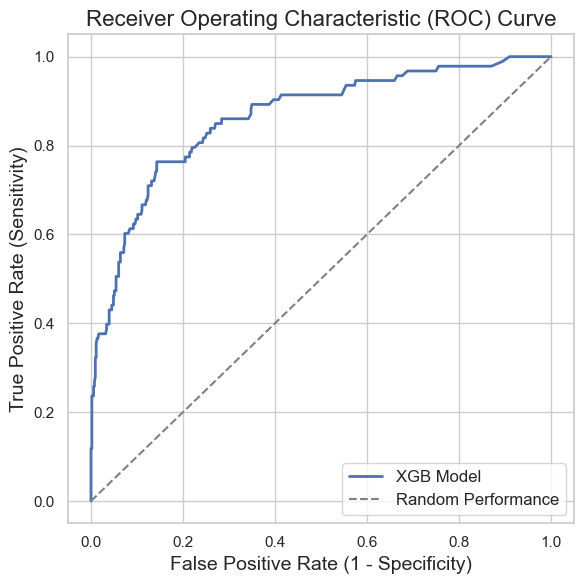

In [706]:
y_prob = opt.best_estimator_.predict_proba(x_test)[:,1]
fprs, tprs = calc_roc_curve(y_test, y_prob)
display_roc_curve([(fprs, tprs)],["XGB Model"])

In [707]:
print(roc_auc_score(y_test, y_prob))

0.8640148758994259


### Sensitivity Analysis

In [708]:
best_model = opt.best_estimator_

In [709]:
hcm_x_test = x_test[x_test.index.isin(hcm_idx)]
hcm_y_test = y_test[y_test.index.isin(hcm_idx)]

hf_x_test = x_test[x_test.index.isin(hf_idx)]
hf_y_test = y_test[y_test.index.isin(hf_idx)]

cong_x_test = x_test[x_test.index.isin(cong_idx)]
cong_y_test = y_test[y_test.index.isin(cong_idx)]

pkRER_x_test = x_test[x_test.index.isin(pkRER_greater_idx)]
pkRER_y_test = y_test[y_test.index.isin(pkRER_greater_idx)]

In [710]:
hcm_pred = best_model.predict(hcm_x_test)
hcm_prob = best_model.predict_proba(hcm_x_test)[:,1]

hf_pred = best_model.predict(hf_x_test)
hf_prob = best_model.predict_proba(hf_x_test)[:,1]

cong_pred = best_model.predict(cong_x_test)
cong_prob = best_model.predict_proba(cong_x_test)[:,1]

pkRER_pred = best_model.predict(pkRER_x_test)
pkRER_prob = best_model.predict_proba(pkRER_x_test)[:,1]

In [712]:
print('HCM roc_auc: ' + str(roc_auc_score(hcm_y_test, hcm_prob)))
print('HF roc_auc: ' + str(roc_auc_score(hf_y_test, hf_prob)))
print('Cong roc_auc: ' + str(roc_auc_score(cong_y_test, cong_prob)))
print('peak RER > 1 roc_auc: ' + str(roc_auc_score(pkRER_y_test, pkRER_prob)))

HCM roc_auc: 0.8524258760107816
HF roc_auc: 0.8713157894736842
Cong roc_auc: 0.9047138047138048
peak RER > 1 roc_auc: 0.8582036439552098


In [ ]:
#Weight the samples
#train with just demographics (gender, age, height, weight) and compare
# add medication features

def mu(pi):
    return .8 + 0.2 * pi
def sigma(pi):
    return np.sqrt(0.0436 * pi**2 - 0.048*pi + 0.0144)
    #return np.sqrt(0.0244 * pi**2 - 0.0288*pi + 0.0144)
pi_val = np.linspace(0,1,100)

muval = mu(pi_val)
sigval = sigma(pi_val)

plt.plot(muval, sigval)
plt.xlabel('Expected Value')
plt.ylabel('Standard Deviation')

### Baseline Model

##### Demographics Only Model

In [253]:
demographics = ['Age', 'Height', 'Weight', 'Gender']

In [256]:
demographics_feat = features[demographics]

In [257]:
x_train_demo, x_test_demo, y_train_demo, y_test_demo = train_test_split(demographics_feat, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)

In [262]:
model_demo = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
opt_demo = BayesSearchCV(model_demo, search_spaces= search_spaces, n_iter= 50, scoring= 'roc_auc', cv=3)

In [263]:
overdone_control = DeltaYStopper(delta=0.0001) 
time_limit_control = DeadlineStopper(total_time=60*60*4)
#opt.fit(X_train, y_train, callback=[overdone_control, time_limit_control])
opt_demo.fit(x_train_demo, y_train_demo, callback=[time_limit_control])

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                             'max_depth': Integer(low=4, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-09, high=100.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-09, high=100.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize')})

In [264]:
y_prob_demo = opt_demo.best_estimator_.predict_proba(x_test_demo)[:,-1]
roc_auc_score(y_test_demo, y_prob_demo)

0.6402902417333656

##### Demographics + Labs Model

In [741]:
demo_labs_features = features[demographics + list(lab_cols)]
x_train_demo_lab, x_test_demo_lab, y_train_demo_lab, y_test_demo_lab = train_test_split(demo_labs_features, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)

In [742]:
model_demo_lab = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
model_demo_lab.fit(x_train_demo_lab, y_train_demo_lab)
y_prob_demo_lab = model_demo_lab.predict_proba(x_test_demo_lab)[:,-1]
roc_auc_score(y_test_demo_lab, y_prob_demo_lab)

0.8087355485487914

##### Demographics + Meds

In [743]:
demo_med_features = features[demographics + list(med_cols)]
x_train_demo_med, x_test_demo_med, y_train_demo_med, y_test_demo_med = train_test_split(demo_med_features, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)

In [744]:
model_demo_med = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
model_demo_med.fit(x_train_demo_med, y_train_demo_med)
y_prob_demo_med = model_demo_med.predict_proba(x_test_demo_med)[:,-1]
roc_auc_score(y_test_demo_med, y_prob_demo_med)

0.7177217236639987

##### Demographics + Labs + Meds

In [745]:
demo_labs_med_features = features[demographics + list(lab_cols) + list(med_cols)]
x_train_demo_lab_med, x_test_demo_lab_med, y_train_demo_lab_med, y_test_demo_lab_med = train_test_split(demo_labs_med_features, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)


In [746]:
model_demo_lab_med = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
model_demo_lab_med.fit(x_train_demo_lab_med, y_train_demo_lab_med)
y_prob_demo_lab_med = model_demo_lab_med.predict_proba(x_test_demo_lab_med)[:,-1]
roc_auc_score(y_test_demo_lab_med, y_prob_demo_lab_med)

0.8429137359527851

1. baseline
2. baseline + labs
3. baseline + meds (maybe but probably not because did not add predictive value)
4. baseline + labs + meds

### Shap Plots

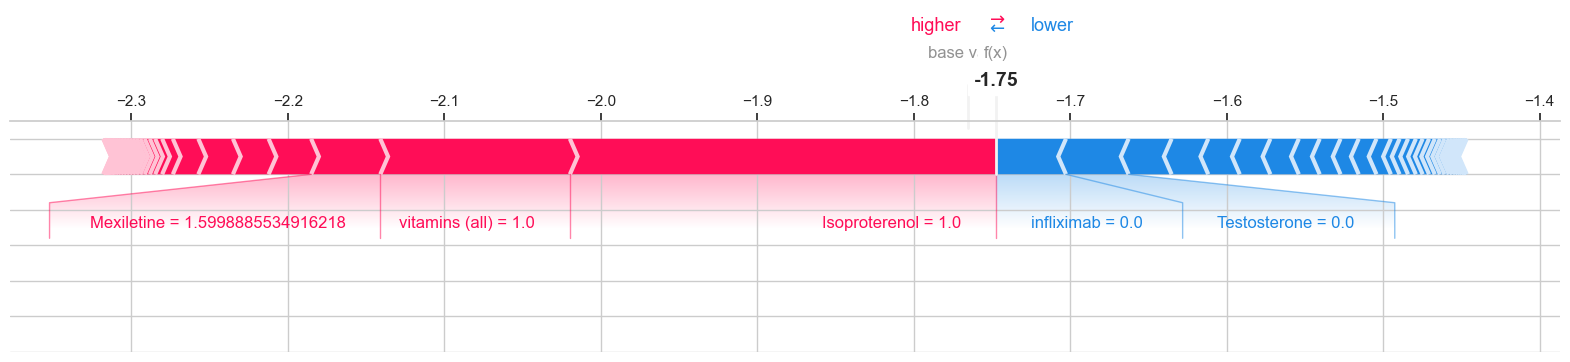

In [733]:
explainer = shap.Explainer(best_model)
shap_values = explainer(x_test)
shap.plots.force(shap_values[0], matplotlib=True, feature_names=med_cols)

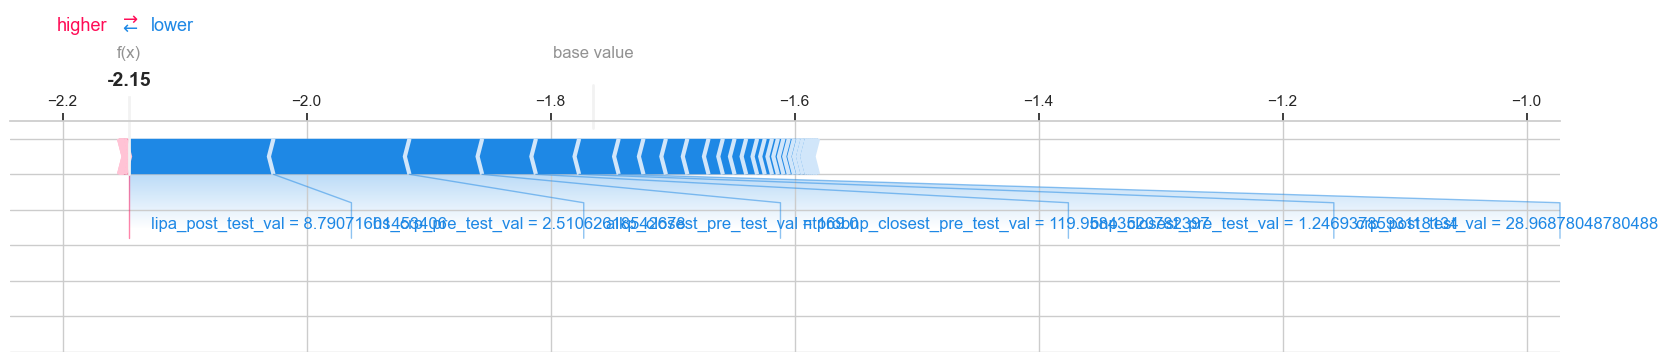

In [735]:
explainer = shap.Explainer(best_model)
shap_values = explainer(x_test)
shap.plots.force(shap_values[1], matplotlib=True, feature_names=lab_cols)

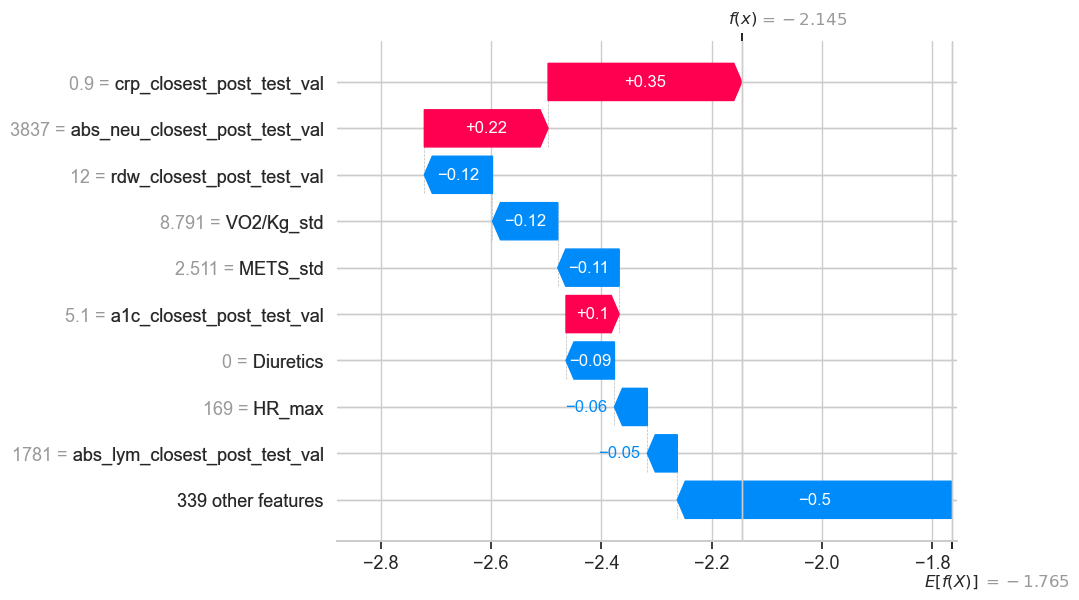

In [738]:
shap.plots.waterfall(shap_values[1])
#pieceworm

In [728]:
'Antiarrythmic' in med_cols

True

**Calibration Curve**

In [112]:
def display_calibration_plot(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    filename: Union[str, None] = None,
):
    # Compute the calibration curve
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=10, strategy='uniform'
    )
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    
    # Add labels and title
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot')
    plt.legend()
    
    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, format='png')
    
    # Show the plot
    plt.show()

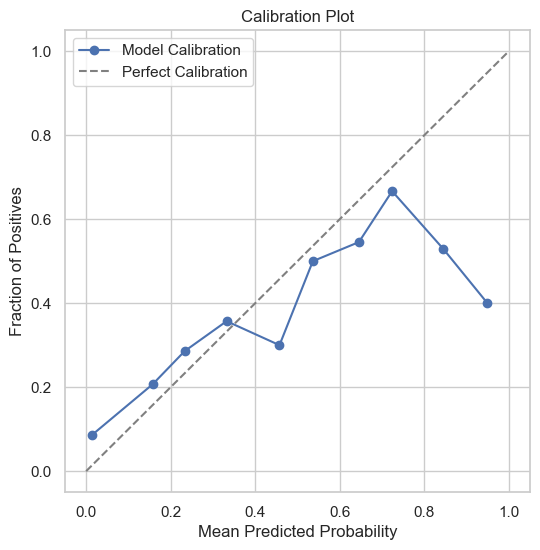

In [113]:
display_calibration_plot(y_test, y_prob)

In [114]:
data.shape

(2081, 115)